# AI-based Prediction Model for Blood-brain Barrier Penetrating Peptides

## Introduction

The idea for this project comes from one of my previous lab works. BBB-penetrating peptides are a specific type of peptide that can conjugate with drugs to penetrate the blood-brain barrier and achieve therapeutic effects.
I previously worked with DEA, a lead BBB-penetrating peptide. Previous studies have found a significant accumulation of DEA in rats' central nervous systems. However, the mechanism of penetration is not yet understood.


![11.png](Images/11.png)


Thus, we synthesized new peptides with several substitutions in the DEA sequence. Then, get some SAR information from in vitro BBB Translocation Assay. However, In vivo or in vitro validation of BBB-penetrating peptide is resource-intensive and time-consuming, so if we want to gain a deeper understanding of the DEA and do further optimization, it’s better to have an accurate prediction method. So, the objective of my project is to **build an AI-based model to predict peptide penetration based on the sequence.**

## 1. Machine Learning-based Prediction 

![22.png](Images/22.png)

In [1]:
import glob
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import pandas as pd
from numpy import genfromtxt
import os
import matplotlib.pyplot as plt

! pip install matplotlib-venn
from matplotlib_venn import venn3


from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn import metrics

Defaulting to user installation because normal site-packages is not writeable


In [2]:
NUMPY_DIR = './npy_res'
CSV_DIR = './csv_res'

In [3]:
csv_pths = glob.glob(os.path.join(CSV_DIR, '*.csv'))
csv_pths

['./csv_res/Dataset_4_Training_N.csv',
 './csv_res/Dataset_1_Validation_P.csv',
 './csv_res/Dataset_4_Training_P.csv',
 './csv_res/Dataset_3_Training_N-2.csv',
 './csv_res/Dataset_2_Validation_N.csv',
 './csv_res/DEA_0_training_P.csv',
 './csv_res/Dataset_1_Training_N.csv',
 './csv_res/Dataset_3_Validation_N.csv',
 './csv_res/DEA_0_training_N.csv',
 './csv_res/Dataset_1_Validation_N.csv',
 './csv_res/Dataset_3_Training_N-1.csv',
 './csv_res/Dataset_2_Training_N.csv',
 './csv_res/Dataset_4_Validation_N.csv',
 './csv_res/Dataset_2_Validation_P.csv',
 './csv_res/Dataset_1_Training_P.csv',
 './csv_res/Dataset_2_Training_P.csv',
 './csv_res/Dataset_3_Training_P.csv',
 './csv_res/Dataset_4_Validation_P.csv',
 './csv_res/Dataset_3_Validation_P.csv']

**Data Collection:**

For data collection, I divided the data into three datasets for training. Positive data for all three datasets came from the B3Pdb database, totaling 269 BBB- penetrating peptides. Negative data for dataset 1 consisted of cell-penetrating peptides that cannot cross the BBB. For datasets 2 and 3, negative data were randomly selected from the non-BBB penetrating peptides database, dataset 3 having ten times entries than dataset 2.

![33.png](Images/33.png)

## (1) Feature Extraction

Next, 15 types of peptide features were generated from the Composition-based Module in Pfeature, totaling 9189 features.

![44.png](Images/44.png)

In [4]:
for csv_pth in csv_pths:
    dataset = genfromtxt(csv_pth, delimiter=',', dtype=None)
    
    dataset = dataset[1:, :]
    
    dataset = dataset.astype('float64')

    csv_base_name_split = os.path.basename(csv_pth[:-4]).split('_')
    
  
    if not os.path.exists(NUMPY_DIR):
        os.makedirs(NUMPY_DIR)      
    npy_name = 'my_dataset_{}_{}_{}.npy'.format(csv_base_name_split[1], csv_base_name_split[2], csv_base_name_split[-1])
    npy_name = os.path.join(NUMPY_DIR, npy_name)
    
    print('save data to {}'.format(npy_name), dataset.shape)
    np.save(npy_name, dataset)

/scratch/local/30025001/ipykernel_1919797/2171106074.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dataset = genfromtxt(csv_pth, delimiter=',', dtype=None)


save data to ./npy_res/my_dataset_4_Training_N.npy (425, 9189)
save data to ./npy_res/my_dataset_1_Validation_P.npy (54, 9189)
save data to ./npy_res/my_dataset_4_Training_P.npy (326, 9189)
save data to ./npy_res/my_dataset_3_Training_N-2.npy (1152, 9189)
save data to ./npy_res/my_dataset_2_Validation_N.npy (54, 9189)
save data to ./npy_res/my_dataset_0_training_P.npy (18, 9189)
save data to ./npy_res/my_dataset_1_Training_N.npy (215, 9189)
save data to ./npy_res/my_dataset_3_Validation_N.npy (538, 9189)
save data to ./npy_res/my_dataset_0_training_N.npy (6, 9189)
save data to ./npy_res/my_dataset_1_Validation_N.npy (54, 9189)
save data to ./npy_res/my_dataset_3_Training_N-1.npy (1000, 9189)
save data to ./npy_res/my_dataset_2_Training_N.npy (215, 9189)
save data to ./npy_res/my_dataset_4_Validation_N.npy (99, 9189)
save data to ./npy_res/my_dataset_2_Validation_P.npy (54, 9189)
save data to ./npy_res/my_dataset_1_Training_P.npy (215, 9189)
save data to ./npy_res/my_dataset_2_Training_

In [5]:

dataset_3s = glob.glob('./npy_res/my_dataset_3_Training_N-*')
datas = []
for dataset_3 in dataset_3s:
    datas += [np.load(dataset_3)]
    
datas = np.concatenate(datas)
print('merge dataset3 to shape: ', datas.shape)
np.save(os.path.join(NUMPY_DIR, 'my_dataset_3_Training_N.npy'), datas)


for dataset_3 in dataset_3s:
    if '-' in dataset_3:
        print('remove {}'.format(dataset_3))
        os.remove(dataset_3)

merge dataset3 to shape:  (2152, 9189)
remove ./npy_res/my_dataset_3_Training_N-2.npy
remove ./npy_res/my_dataset_3_Training_N-1.npy


## (2) Feature Selection


From these 9189 features, those with higher importance were selected using SVC-L1 for model training. The final selection for the three datasets was 56, 50, and 117 features, respectively.


In [6]:
feature_names_result = list(pd.read_csv(csv_pths[0]).columns)

In [7]:
def calculate_importance(data_p_pth, data_n_pth, data_idx):
    '''
    Parameters
    ----------
    data_p_pth : string. The path of the positive data
    data_n_pth : string. The path of the negative data
    data_idx   : int. The index of the dataset, which is used in the title of the figure.

    Returns
    -------
    X_new : numpy array. The new feautres.
    names : list of selected important features of their names.
    importance : list of selected features with their importance.
    selector : the model for selecting features
    '''
    x_1_p = np.load(data_p_pth, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
    y_1_p = np.ones((x_1_p.shape[0]))
    
    x_1_n = np.load(data_n_pth, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
    y_1_n = np.zeros((x_1_n.shape[0]))
    
    X = np.concatenate((x_1_p, x_1_n))
    Y = np.concatenate((y_1_p, y_1_n))
    X, Y = shuffle(X, Y)
    
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
    selector = SelectFromModel(lsvc).fit(X, Y)
    X_new = selector.transform(X)
    
    names = np.array(feature_names_result)[selector.get_support()].tolist()
    importance =selector.estimator_.coef_[0][selector.get_support()].tolist()
    importance_abs,names, importance = zip(*sorted(zip(abs(np.array(importance)),names, importance)))
    title = 'Feature selection from dataset {}: {} to {}'.format(data_idx, X.shape[1], X_new.shape[1])
    
    H = 17
    if len(importance) > 100:
        H = 25
    plt.figure(figsize=(10,H))
    plt.title(title)
    plt.barh(range(len(names)), abs(np.array(importance)), align='center', color='skyblue', label = 'absolute value of importance value')#, alpha=0.5)
    plt.barh(range(len(names)), importance, align='center', label = 'orginal value')
    plt.yticks(range(len(names)), names)
    plt.legend()
    plt.show()
    
    return X_new, Y, names, importance, selector



/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


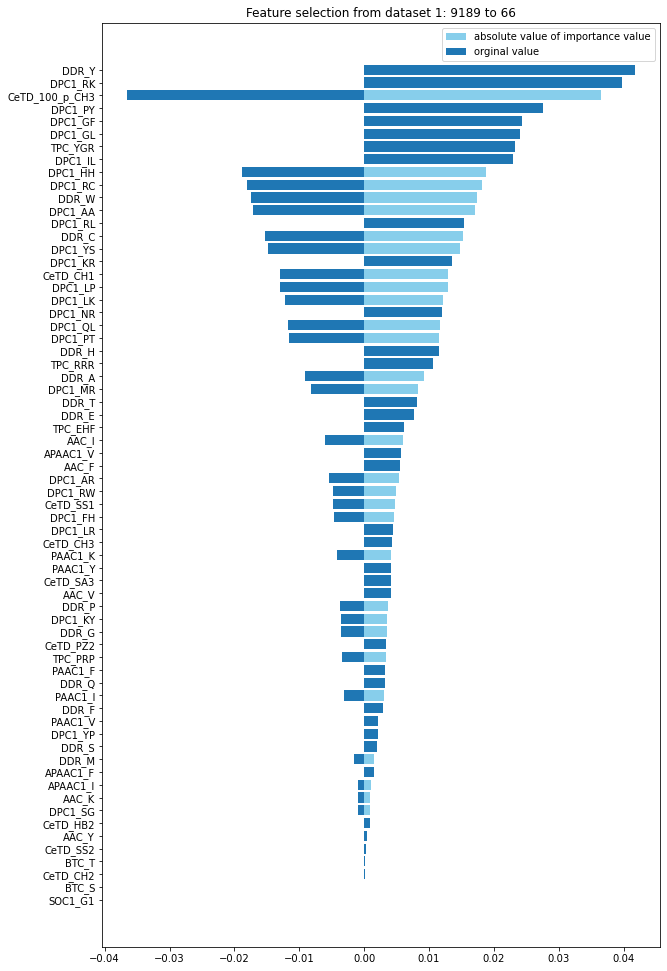

In [8]:
# feautre selection from dataset 1
X_new1, Y1, f1, inp1, selec1 = calculate_importance('./npy_res/my_dataset_1_Training_P.npy', './npy_res/my_dataset_1_Training_N.npy', 1)

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


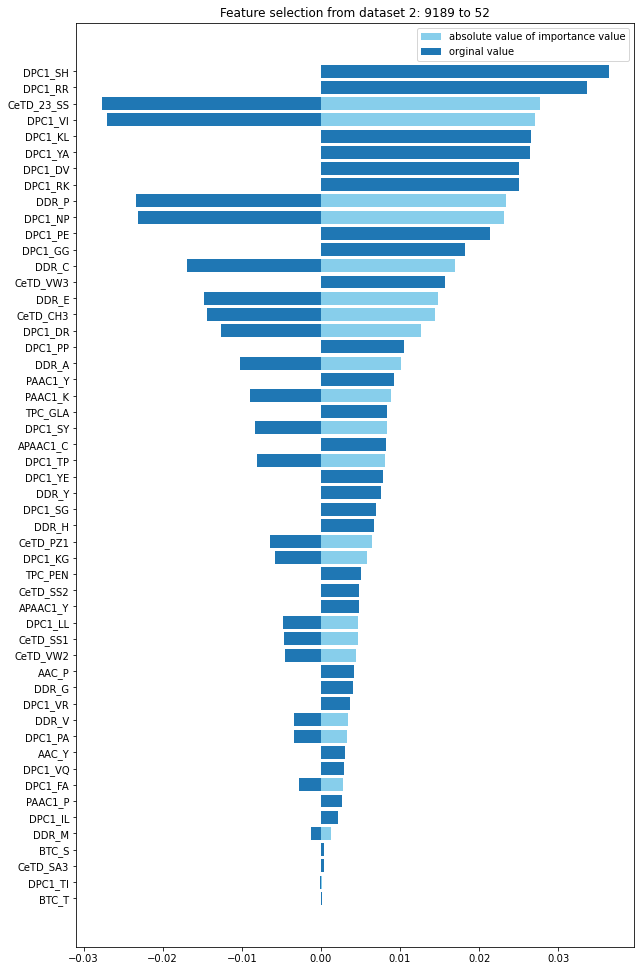

In [9]:
# feautre selection from dataset 2
X_new2, Y2,f2, inp2, selec2 = calculate_importance('./npy_res/my_dataset_2_Training_P.npy', './npy_res/my_dataset_2_Training_N.npy', 2)

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


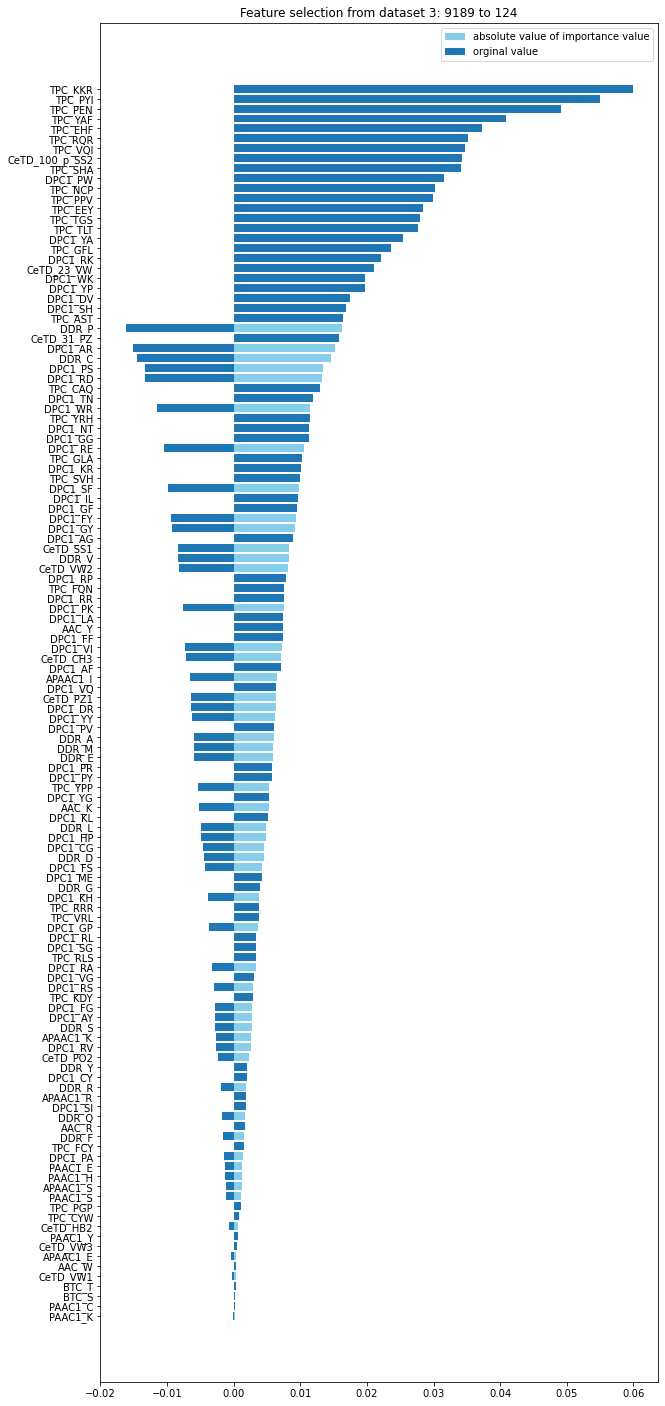

In [10]:
# feautre selection from dataset 3
X_new3, Y3,f3, inp3, selec3 = calculate_importance('./npy_res/my_dataset_3_Training_P.npy', './npy_res/my_dataset_3_Training_N.npy', 3)

## (3) Analyze the number of selected features from 3 datasets

overlapped important features from 3 datasets:
{'DDR_A', 'BTC_T', 'DDR_C', 'DPC1_SG', 'CeTD_CH3', 'CeTD_SS1', 'BTC_S', 'DPC1_IL', 'PAAC1_Y', 'AAC_Y', 'DDR_M', 'DDR_E', 'DDR_Y', 'PAAC1_K', 'DDR_G', 'DDR_P', 'DPC1_RK'}


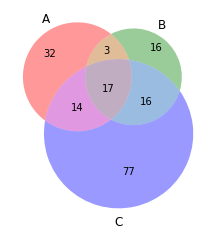

In [11]:
venn3(subsets=[set(f1), set(f2), set(f3)])
print('overlapped important features from 3 datasets:')
print(set(f1).intersection(set(f2)).intersection(set(f3)))

## (4) Classifier Comparison Method 

These selected features and the corresponding data were then used for model training on 9 different classifiers.

In [12]:
classifier_names = ['Linear SVM', 'KNN', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'Neural Net',\
                   'AdaBoost', 'Naive Bayes', 'QDA']
classifers = [SVC(kernel="linear", C=0.025, probability=True), \
             KNeighborsClassifier(3), \
             GaussianProcessClassifier(1.0 * RBF(1.0), max_iter_predict=10), \
             DecisionTreeClassifier(max_depth=5), \
             RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
             MLPClassifier(alpha=1, max_iter=1000), \
             AdaBoostClassifier(), \
             GaussianNB(), \
             QuadraticDiscriminantAnalysis()]

Results for dataset 1
         Classifier  Accuracy  Precision    Recall        F1     AUROC
0        Linear SVM  0.740741   0.750000  0.722222  0.735849  0.806413
1               KNN  0.620370   0.622642  0.611111  0.616822  0.630487
2  Gaussian Process  0.500000   0.500000  0.018519  0.035714  0.555556
3     Decision Tree  0.694444   0.705882  0.666667  0.685714  0.677984
4     Random Forest  0.768519   0.784314  0.740741  0.761905  0.818587
5        Neural Net  0.740741   0.696970  0.851852  0.766667  0.842421
6          AdaBoost  0.722222   0.700000  0.777778  0.736842  0.772291
7       Naive Bayes  0.731481   0.745098  0.703704  0.723810  0.754458
8               QDA  0.685185   0.672414  0.722222  0.696429  0.713134


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


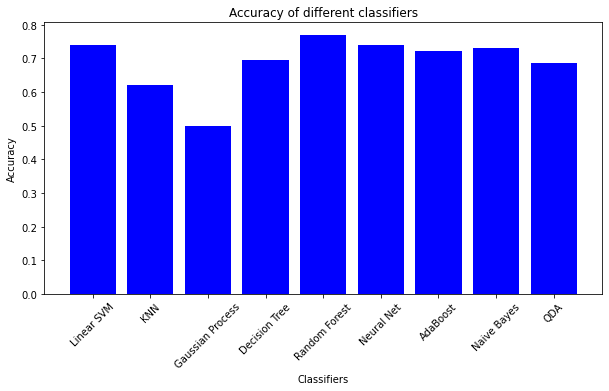

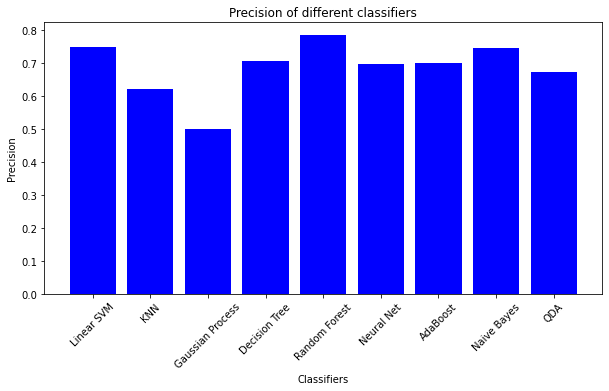

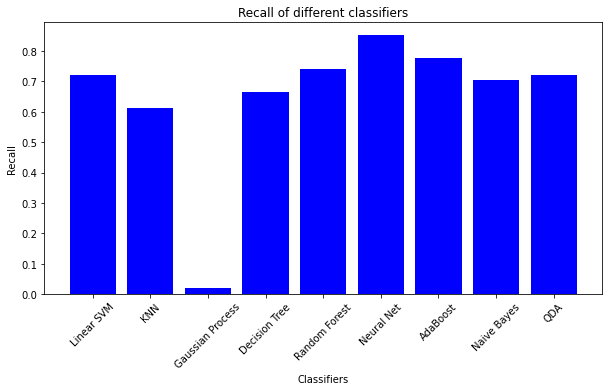

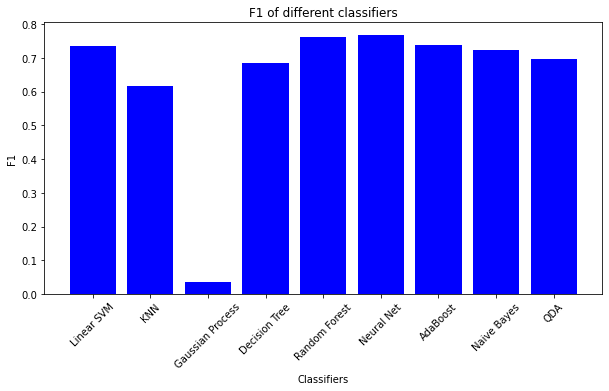

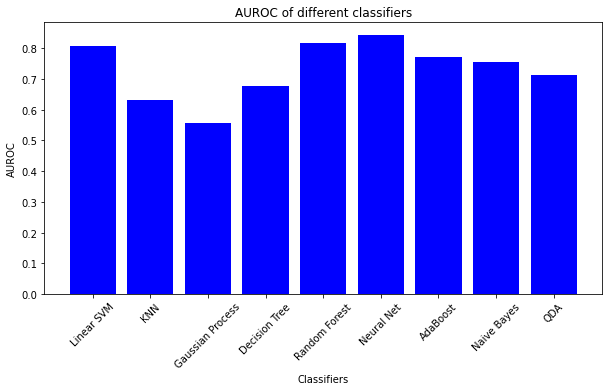

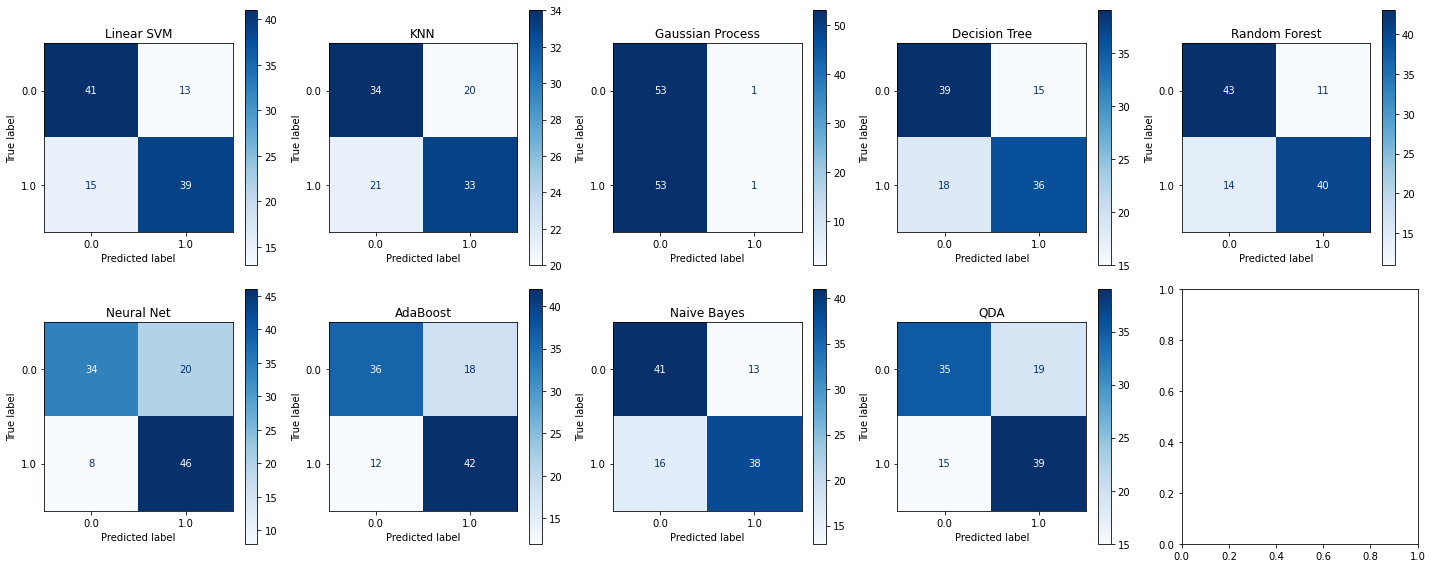

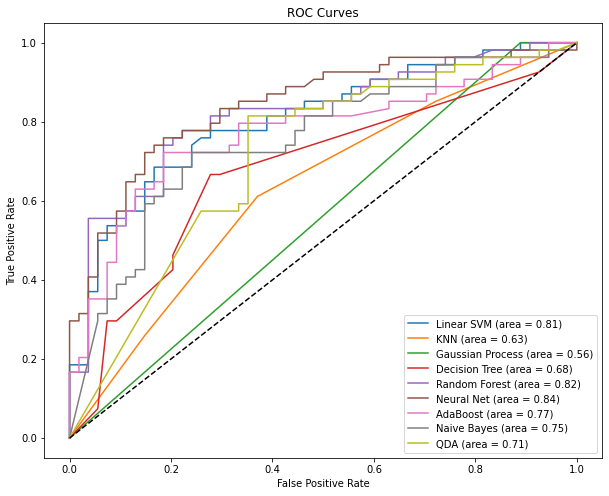

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, roc_curve, auc

def train_models_and_evaluate(X, Y, selector, x_test_pths, classifiers, classifier_names):
    X_train = X
    Y_train = Y

    X_valid_list = []
    Y_valid_list = []
    for x_test_pth in x_test_pths:
        tmp_x_valid = np.load(x_test_pth, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
        X_valid_list.append(tmp_x_valid)
        if 'P' in x_test_pth:
            Y_valid_list.append(np.ones(tmp_x_valid.shape[0]))
        else:
            Y_valid_list.append(np.zeros(tmp_x_valid.shape[0]))

    X_valid = np.concatenate(X_valid_list)
    Y_valid = np.concatenate(Y_valid_list)
    X_valid_transformed = selector.transform(X_valid)

    metrics_dict = {'Classifier': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], 'AUROC': []}

    for clf_name, clf in zip(classifier_names, classifiers):
        clf.fit(X_train, Y_train)
        pred = clf.predict(X_valid_transformed)
        pred_proba = clf.predict_proba(X_valid_transformed)[:, 1]

        metrics_dict['Classifier'].append(clf_name)
        metrics_dict['Accuracy'].append(metrics.accuracy_score(Y_valid, pred))
        metrics_dict['Precision'].append(metrics.precision_score(Y_valid, pred))
        metrics_dict['Recall'].append(metrics.recall_score(Y_valid, pred))
        metrics_dict['F1'].append(metrics.f1_score(Y_valid, pred))
        metrics_dict['AUROC'].append(metrics.roc_auc_score(Y_valid, pred_proba))

    metrics_df = pd.DataFrame(metrics_dict)
    print(metrics_df)


    for metric in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC']:
        plt.figure(figsize=(10, 5))
        plt.bar(metrics_df['Classifier'], metrics_df[metric], color='blue')
        plt.xlabel('Classifiers')
        plt.ylabel(metric)
        plt.title(f'{metric} of different classifiers')
        plt.xticks(rotation=45)
        # plt.savefig(f"metrics_plot_{metric}.png") 
        plt.show()


    fig, axes = plt.subplots(nrows=2, ncols=(len(classifiers) + 1) // 2, figsize=(20, 8))
    axes = axes.flatten()
    for ax, clf, name in zip(axes, classifiers, classifier_names):
        plot_confusion_matrix(clf, X_valid_transformed, Y_valid, ax=ax, cmap='Blues')
        ax.title.set_text(name)
    plt.tight_layout()
    # plt.savefig("confusion_matrices.png") 
    plt.show()


    plt.figure(figsize=(10, 8))
    for clf, name in zip(classifiers, classifier_names):
        pred_proba = clf.predict_proba(X_valid_transformed)[:, 1]
        fpr, tpr, _ = roc_curve(Y_valid, pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    # plt.savefig("roc_curves.png") 
    plt.show()

print('Results for dataset 1')
print('=====================')
train_models_and_evaluate(X_new1, Y1, selec1, ['./npy_res/my_dataset_1_Validation_P.npy', './npy_res/my_dataset_1_Validation_N.npy'], classifers, classifier_names)


Results for dataset 2
         Classifier  Accuracy  Precision    Recall        F1     AUROC
0        Linear SVM  0.750000   0.714286  0.833333  0.769231  0.816872
1               KNN  0.777778   0.767857  0.796296  0.781818  0.806070
2  Gaussian Process  0.777778   0.741935  0.851852  0.793103  0.859053
3     Decision Tree  0.675926   0.693878  0.629630  0.660194  0.596879
4     Random Forest  0.694444   0.672131  0.759259  0.713043  0.758402
5        Neural Net  0.750000   0.714286  0.833333  0.769231  0.854252
6          AdaBoost  0.722222   0.687500  0.814815  0.745763  0.805556
7       Naive Bayes  0.666667   0.645161  0.740741  0.689655  0.722222
8               QDA  0.574074   0.541667  0.962963  0.693333  0.655007


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


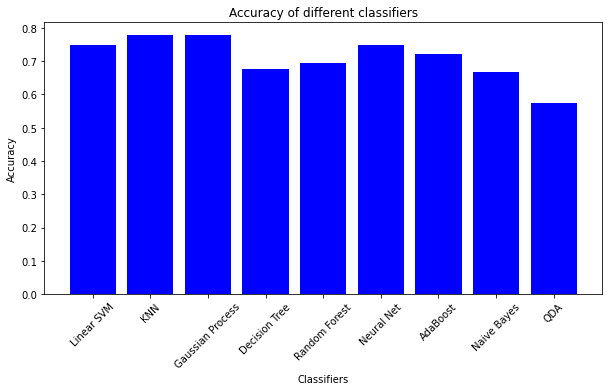

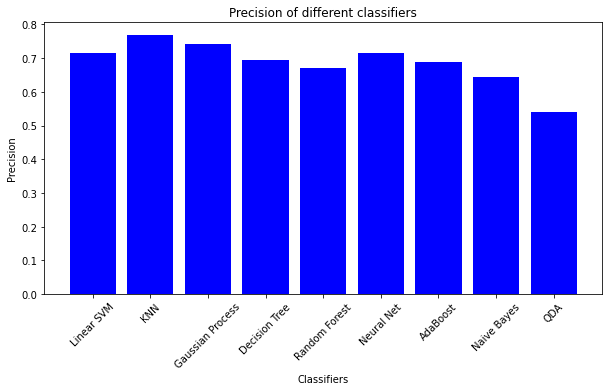

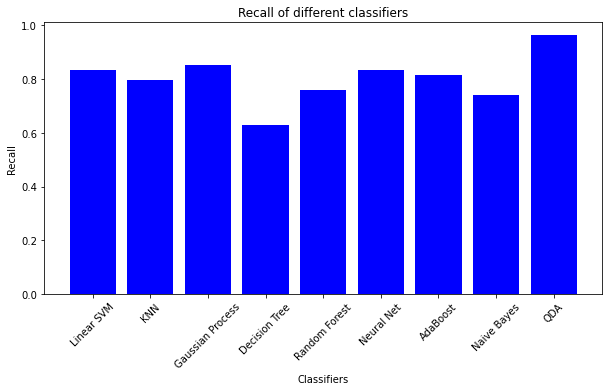

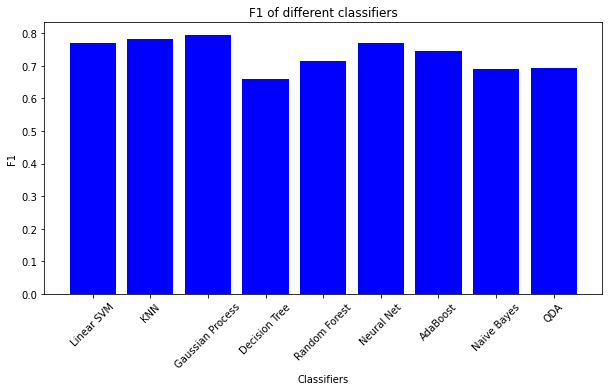

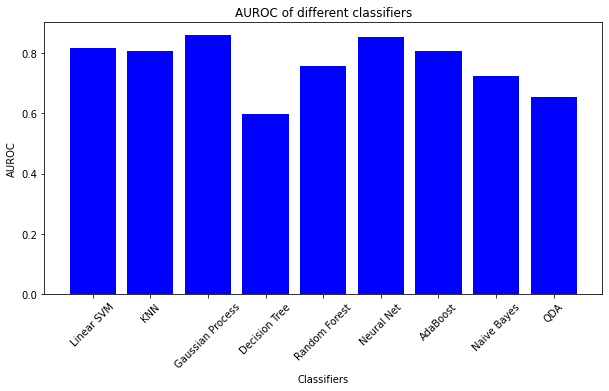

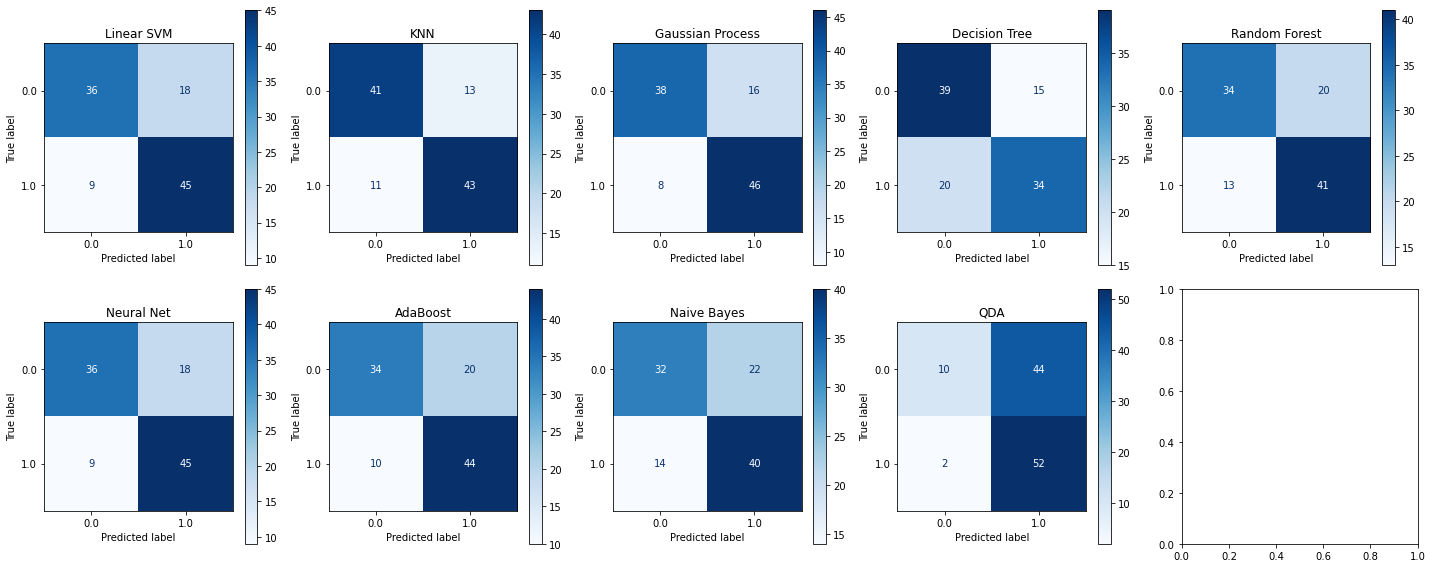

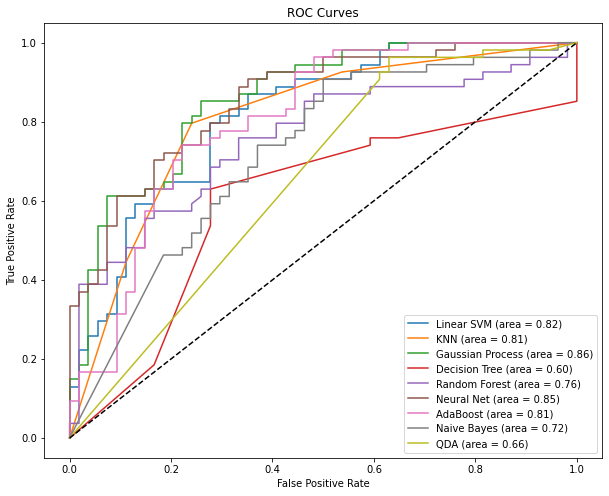

In [14]:
print('Results for dataset 2')
print('=====================')
train_models_and_evaluate(X_new2, Y2, selec2, ['./npy_res/my_dataset_2_Validation_P.npy', './npy_res/my_dataset_2_Validation_N.npy'], classifers, classifier_names)


Results for dataset 3


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


         Classifier  Accuracy  Precision    Recall        F1     AUROC
0        Linear SVM  0.940878   0.731707  0.555556  0.631579  0.825313
1               KNN  0.932432   0.694444  0.462963  0.555556  0.829994
2  Gaussian Process  0.947635   0.794872  0.574074  0.666667  0.860285
3     Decision Tree  0.927365   0.761905  0.296296  0.426667  0.781065
4     Random Forest  0.908784   0.000000  0.000000  0.000000  0.844623
5        Neural Net  0.944257   0.838710  0.481481  0.611765  0.847584
6          AdaBoost  0.927365   0.634146  0.481481  0.547368  0.907786
7       Naive Bayes  0.903716   0.478261  0.611111  0.536585  0.794059
8               QDA  0.930743   0.651163  0.518519  0.577320  0.770962


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


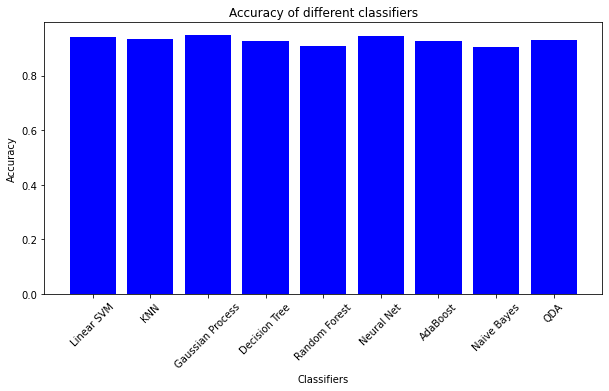

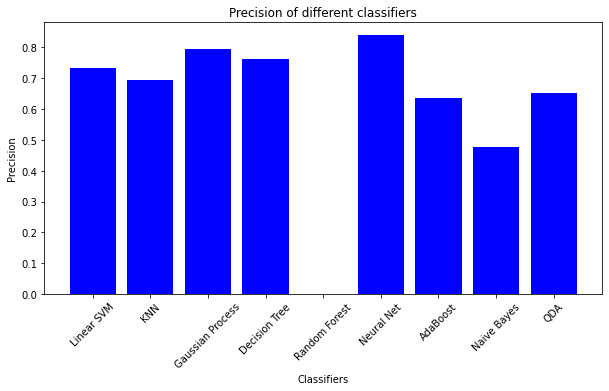

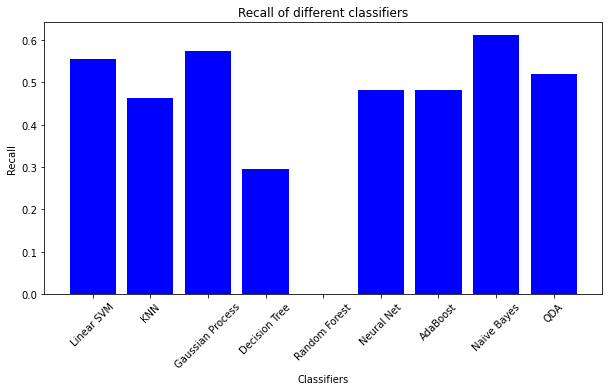

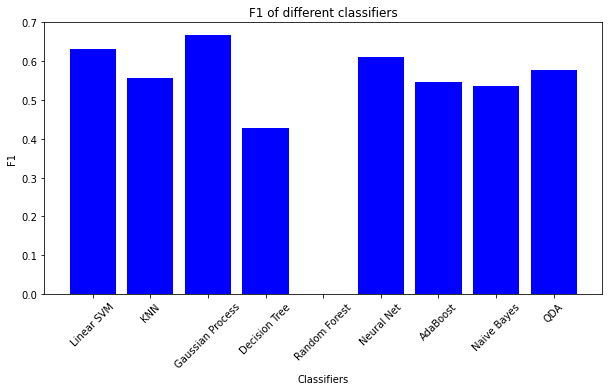

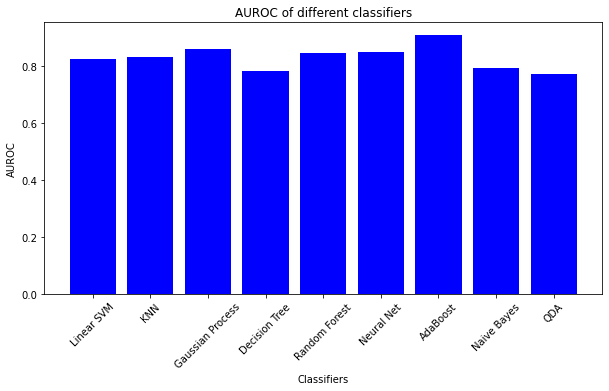

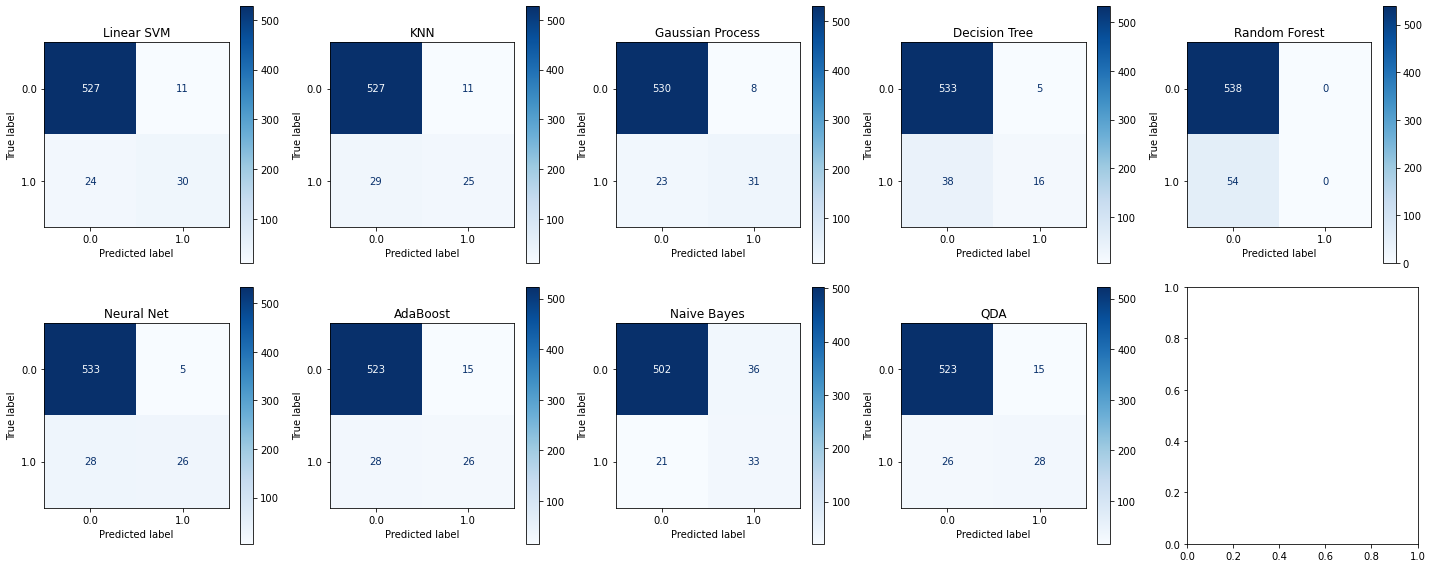

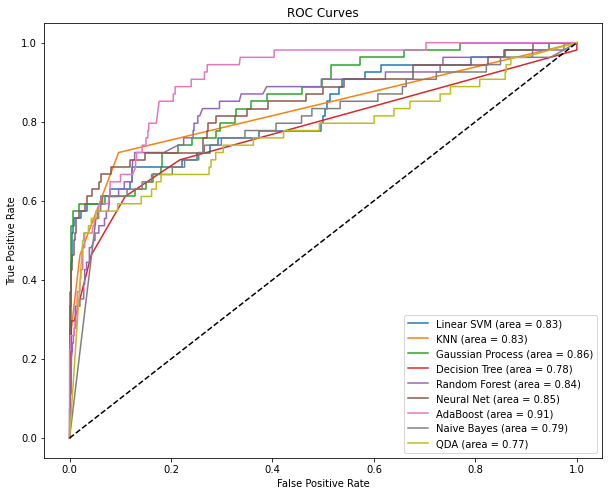

In [15]:
print('Results for dataset 3')
print('=====================')
train_models_and_evaluate(X_new3, Y3, selec3, ['./npy_res/my_dataset_3_Validation_P.npy', './npy_res/my_dataset_3_Validation_N.npy'], classifers, classifier_names)

### Summary:

For dataset 1, Random Forest had the best accuracy at 0.76 and the highest precision score, F1 score, and ROC compared to other classifiers.

For dataset 2, KNN and Random forest had the best accuracy at 0.79.

For dataset 3, 9 classifiers can reach an accuracy of around 0.9. However, the confusion matrix shows that the model tends to predict a negative result. This is due to the imbalanced dataset.


# 2. Sequential Model_LSTM

Next, I tried using the deep learning method, the LSTM model, for training. LSTMs are particularly apt for peptide sequences because they can capture sequential information.

![55.png](Images/55.png)

## (1) Training data: Dataset 2

First, I train the model using training dataset 2. The model reaches an accuracy of around 0.78, which is slightly better than Random Forest and KNN. The recall, F1, and AUROC scores are also higher.

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

file_list = glob.glob('/blue/bsc4892/Hsin-Ying/BBB Project/data_new/*.txt')  


dataframes = [] 
for file in file_list:
    df = pd.read_csv(file, sep="\t", header=None)  
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


sequences = combined_df[0].values  
labels = combined_df[1].values.astype(int)  


tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)


X = pad_sequences(encoded_seqs, padding='post')


x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding



vocab_size = 20 


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


2024-04-26 17:27:04.755376: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 17:27:05.565731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


Epoch 1/10


2024-04-26 17:27:09.121949: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-04-26 17:27:10.898664: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - 5s 54ms/step - loss: 0.6926 - accuracy: 0.5087 - val_loss: 0.6814 - val_accuracy: 0.6860
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.6607 - accuracy: 0.6541 - val_loss: 0.5600 - val_accuracy: 0.7442
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5644 - accuracy: 0.7180 - val_loss: 0.5199 - val_accuracy: 0.7093
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.5120 - accuracy: 0.7500 - val_loss: 0.5053 - val_accuracy: 0.7442
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.4867 - accuracy: 0.7674 - val_loss: 0.5016 - val_accuracy: 0.7558
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.4656 - accuracy: 0.7762 - val_loss: 0.5136 - val_accuracy: 0.7442
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.4768 - accuracy: 0.7703 - val_loss: 0.5154 - val_accuracy: 0.7326
Epoch 8/10
11/11 [============

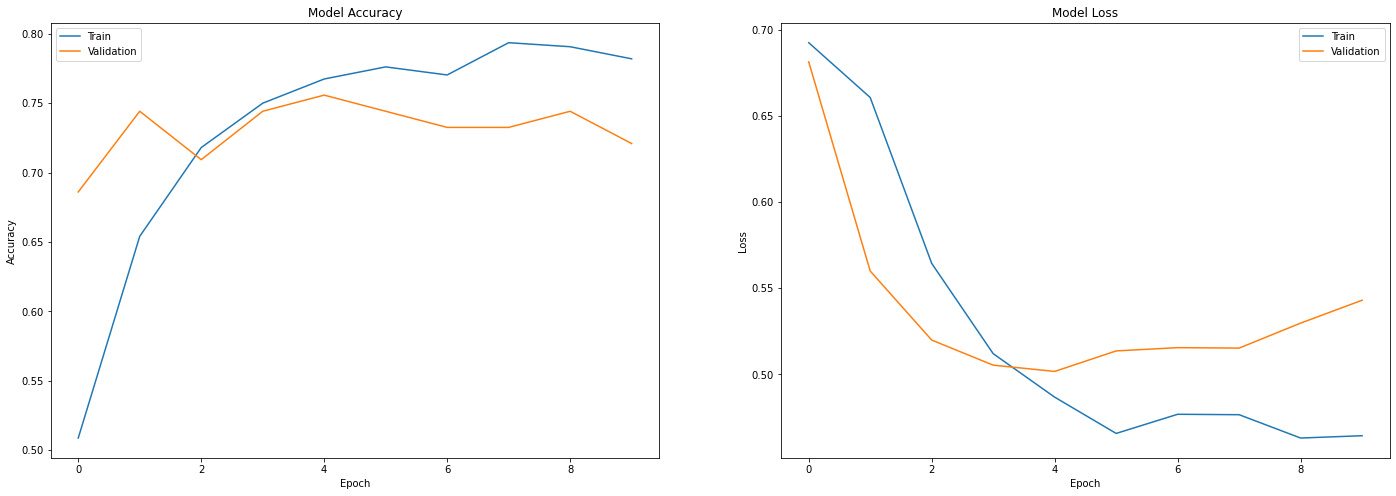

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
# plt.savefig('model_accuracy_and_loss.png') 
plt.show()


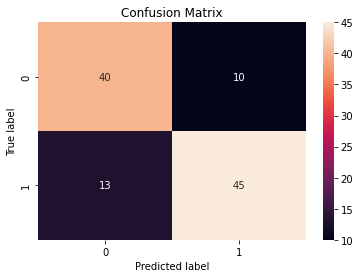

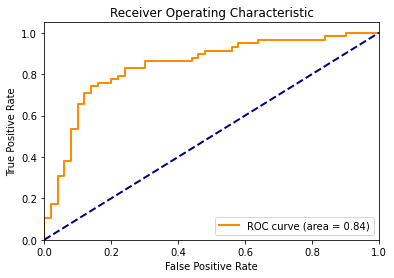

Accuracy: 0.7870370370370371
Precision: 0.8181818181818182
Recall: 0.7758620689655172
F1 Score: 0.7964601769911505
ROC AUC Score: 0.8403448275862069


In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score


y_pred = (model.predict(x_test) > 0.5).astype("int32")


cm = confusion_matrix(y_test, y_pred)


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


y_pred_prob = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")


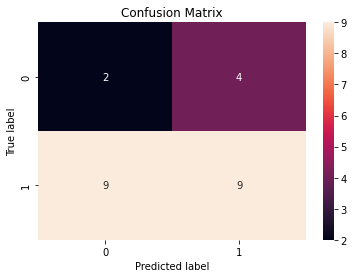

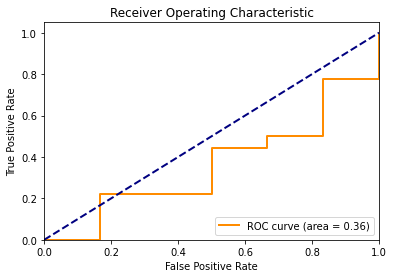

Accuracy: 0.4583333333333333
Precision: 0.6923076923076923
Recall: 0.5
F1 Score: 0.5806451612903226
ROC AUC Score: 0.3611111111111111


In [20]:
file_list = glob.glob('/blue/bsc4892/Hsin-Ying/BBB Project/data_DEA/*.txt')  


dataframes = [] 
for file in file_list:
    df = pd.read_csv(file, sep="\t", header=None)  
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


sequences = combined_df[0].values  
labels = combined_df[1].values.astype(int)  


tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)


x_test_experiment = pad_sequences(encoded_seqs, padding='post')
y_test_experiment = np.array(labels)


y_pred_experiment = (model.predict(x_test_experiment) > 0.5).astype("int32")


cm = confusion_matrix(y_test_experiment, y_pred_experiment)


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix.png') 
plt.show()


y_pred_prob = model.predict(x_test_experiment).ravel()
fpr, tpr, thresholds = roc_curve(y_test_experiment, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


accuracy = accuracy_score(y_test_experiment, y_pred_experiment)
precision = precision_score(y_test_experiment, y_pred_experiment)
recall = recall_score(y_test_experiment, y_pred_experiment)
f1 = f1_score(y_test_experiment, y_pred_experiment)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

## (2) Training data: Dataset 3

When using training dataset 3, similar to the previous result, with high accuracy but tends to predict the negative result, showing LSTM cannot deal with imbalanced data as well.


In [21]:


file_list = glob.glob('/blue/bsc4892/Hsin-Ying/BBB Project/data_del/*.txt')  


dataframes = [] 
for file in file_list:
    df = pd.read_csv(file, sep="\t", header=None)  
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


sequences = combined_df[0].values  
labels = combined_df[1].values.astype(int)  


tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)


X = pad_sequences(encoded_seqs, padding='post')


x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [22]:

vocab_size = 20 


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
60/60 [==============================] - 2s 13ms/step - loss: 0.3562 - accuracy: 0.9012 - val_loss: 0.2756 - val_accuracy: 0.9219
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2924 - accuracy: 0.9144 - val_loss: 0.2566 - val_accuracy: 0.9219
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2484 - accuracy: 0.9197 - val_loss: 0.2153 - val_accuracy: 0.9346
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2169 - accuracy: 0.9245 - val_loss: 0.2034 - val_accuracy: 0.9367
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2118 - accuracy: 0.9250 - val_loss: 0.2005 - val_accuracy: 0.9346
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2105 - accuracy: 0.9297 - val_loss: 0.1997 - val_accuracy: 0.9346
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2078 - accuracy: 0.9303 - val_loss: 0.2022 - val_accuracy: 0.9346
Epoch 8/10
60/60 [=

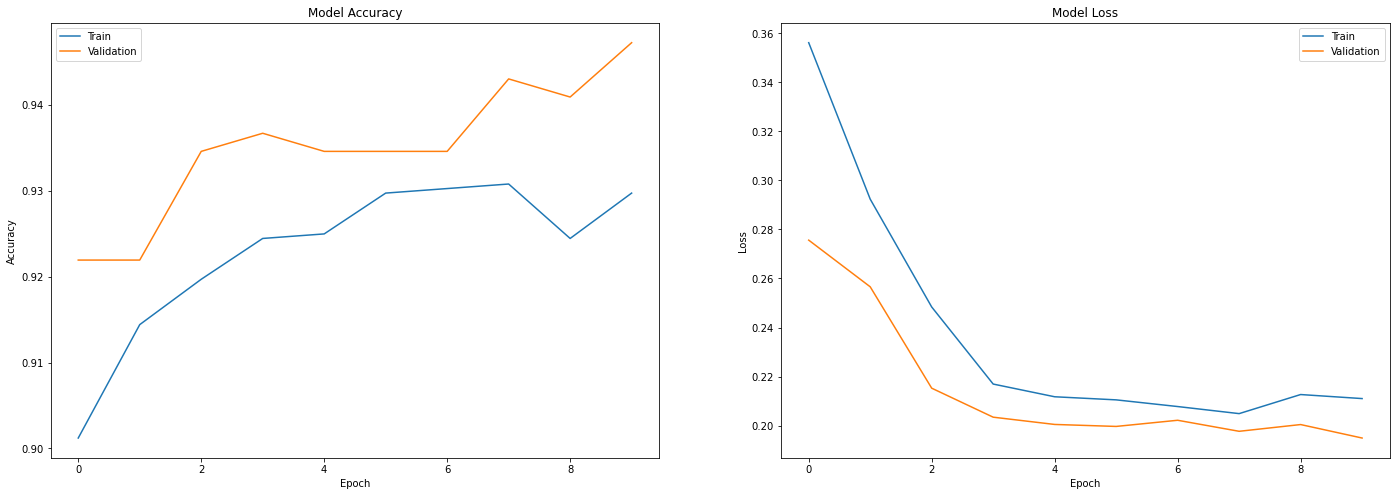

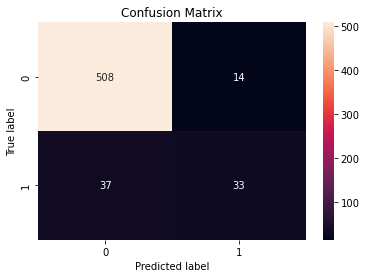

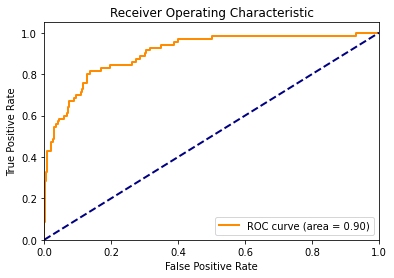

Accuracy: 0.9138513513513513
Precision: 0.7021276595744681
Recall: 0.4714285714285714
F1 Score: 0.5641025641025642
ROC AUC Score: 0.9042145593869731


In [24]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
# plt.savefig('model_accuracy_and_loss.png') 
plt.show()



from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score


y_pred = (model.predict(x_test) > 0.5).astype("int32")


cm = confusion_matrix(y_test, y_pred)


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


y_pred_prob = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")



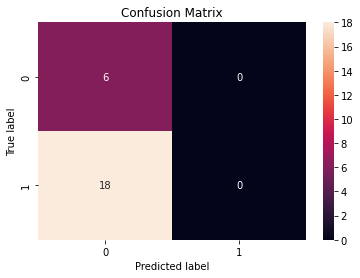

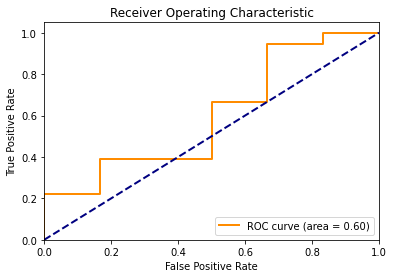

Accuracy: 0.25
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.6018518518518519


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
file_list = glob.glob('/blue/bsc4892/Hsin-Ying/BBB Project/data_DEA/*.txt')  


dataframes = [] 
for file in file_list:
    df = pd.read_csv(file, sep="\t", header=None)  
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


sequences = combined_df[0].values  
labels = combined_df[1].values.astype(int)  


tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)


x_test_experiment = pad_sequences(encoded_seqs, padding='post')
y_test_experiment = np.array(labels)


y_pred_experiment = (model.predict(x_test_experiment) > 0.5).astype("int32")


cm = confusion_matrix(y_test_experiment, y_pred_experiment)


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig('confusion matrix.png') 
plt.show()


y_pred_prob = model.predict(x_test_experiment).ravel()
fpr, tpr, thresholds = roc_curve(y_test_experiment, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


accuracy = accuracy_score(y_test_experiment, y_pred_experiment)
precision = precision_score(y_test_experiment, y_pred_experiment)
recall = recall_score(y_test_experiment, y_pred_experiment)
f1 = f1_score(y_test_experiment, y_pred_experiment)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Although LSTM shows a similar or slightly better performance than previous classifiers, when testing on the assay data, the accuracy is pretty low for both training dataset. So, the next method is to add augmented data for both positive and negative data.

## (3) Training data: Augumented data

The method for data augmentation is random masking. The new data set has around 7,500 entries. The overall performance with the augmented data is improved. It also could better predict both true positive and negative data.

In [26]:


file_list = glob.glob('/blue/bsc4892/Hsin-Ying/BBB Project/final_combined_data.txt')  




dataframes = [] 
for file in file_list:
    df = pd.read_csv(file, sep="\t", header=None)  
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


sequences = combined_df[0].values  
labels = combined_df[1].values.astype(int)  


tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)


X = pad_sequences(encoded_seqs, padding='post')


x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


vocab_size = 20 


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=35, batch_size=32, validation_split=0.2)

Epoch 1/35
377/377 [==============================] - 4s 6ms/step - loss: 0.4835 - accuracy: 0.7720 - val_loss: 0.4522 - val_accuracy: 0.7946
Epoch 2/35
377/377 [==============================] - 2s 5ms/step - loss: 0.4081 - accuracy: 0.8152 - val_loss: 0.4143 - val_accuracy: 0.7995
Epoch 3/35
377/377 [==============================] - 2s 5ms/step - loss: 0.3789 - accuracy: 0.8313 - val_loss: 0.3890 - val_accuracy: 0.8102
Epoch 4/35
377/377 [==============================] - 2s 5ms/step - loss: 0.3280 - accuracy: 0.8569 - val_loss: 0.3114 - val_accuracy: 0.8560
Epoch 5/35
377/377 [==============================] - 2s 5ms/step - loss: 0.3025 - accuracy: 0.8685 - val_loss: 0.3002 - val_accuracy: 0.8633
Epoch 6/35
377/377 [==============================] - 2s 5ms/step - loss: 0.2684 - accuracy: 0.8823 - val_loss: 0.2835 - val_accuracy: 0.8792
Epoch 7/35
377/377 [==============================] - 2s 5ms/step - loss: 0.2445 - accuracy: 0.8929 - val_loss: 0.2474 - val_accuracy: 0.8828
Epoch 

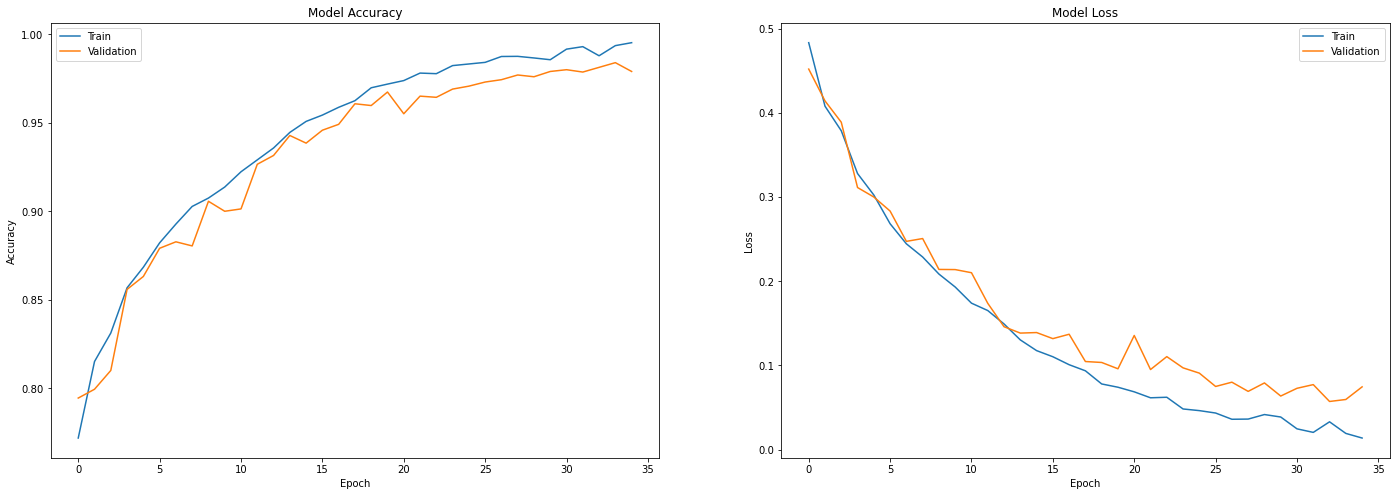

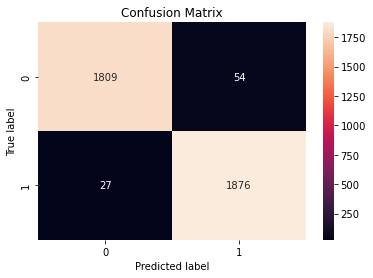

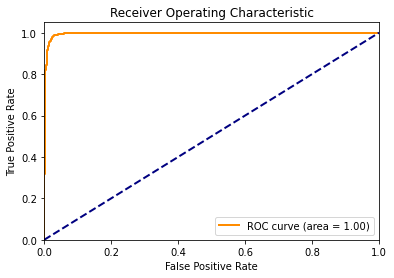

Accuracy: 0.9784917684545937
Precision: 0.9720207253886011
Recall: 0.9858118759852864
F1 Score: 0.9788677276284895
ROC AUC Score: 0.9959128860862965


In [27]:

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('model_accuracy_and_loss.png') 
plt.show()


from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score


y_pred = (model.predict(x_test) > 0.5).astype("int32")


cm = confusion_matrix(y_test, y_pred)


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('1') 
plt.show()


y_pred_prob = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('2') 
plt.show()


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")



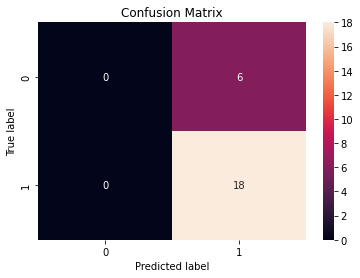

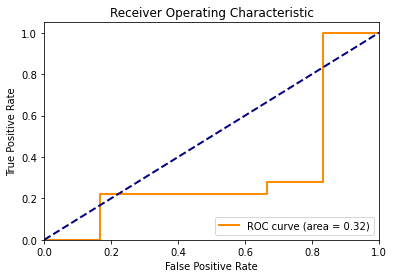

Accuracy: 0.75
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571
ROC AUC Score: 0.32407407407407407


In [28]:
file_list = glob.glob('/blue/bsc4892/Hsin-Ying/BBB Project/data_DEA/*.txt')  


dataframes = [] 
for file in file_list:
    df = pd.read_csv(file, sep="\t", header=None)  
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


sequences = combined_df[0].values  
labels = combined_df[1].values.astype(int)  


tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_seqs = tokenizer.texts_to_sequences(sequences)


x_test_experiment = pad_sequences(encoded_seqs, padding='post')
y_test_experiment = np.array(labels)


y_pred_experiment = (model.predict(x_test_experiment) > 0.5).astype("int32")


cm = confusion_matrix(y_test_experiment, y_pred_experiment)


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix.png') 
plt.show()


y_pred_prob = model.predict(x_test_experiment).ravel()
fpr, tpr, thresholds = roc_curve(y_test_experiment, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


accuracy = accuracy_score(y_test_experiment, y_pred_experiment)
precision = precision_score(y_test_experiment, y_pred_experiment)
recall = recall_score(y_test_experiment, y_pred_experiment)
f1 = f1_score(y_test_experiment, y_pred_experiment)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

When testing on the assay data, the accuracy also significantly improved to 0.7.

# **Comparision of Prediction on Assay Data**

![66.png](Images/66.png)

# 2. Conclusion
(1) **For Machine Learning-based Prediction**, using a random forest with selected features could reach an accuracy of 0.79. Sequence features could provide more information for optimization and SAR analysis.

(2) **For the Deep Learning-based method**, the performance of the LSTM model is sensitive to the quantity and quality of the training data. 8x augmented data could reach an accuracy of 0.98. 

(3) **Limitations of this project**:
The assay dataset for testing is small and contains only a single mutation for each peptide. The BBB-penetrating peptides database also has limited data. So, the model cannot identify the slight difference between single mutation data, so the accuracy of classifying assay data is relatively low.